In [1]:
import pandas as pd # python data manipulation and analysis library
import numpy as np #  Library with large collection of high-level mathematical functions to operate on arrays
import matplotlib.pyplot as plt #python plotting library
import peakutils #baselining library

from scipy.optimize import curve_fit
import os,glob
 # Library with operating system dependent functionality. Example: Reading data from files on the computer

import csv
from pathlib import *
import mplcursors

from sklearn import preprocessing

from lmfit import Parameters, minimize
from scipy import stats
# import re

In [2]:
def new_plot_LIG(d1,d2,_d1,_d2,e):
    """Plots LIG BEFORE PATTERN and get saves fits as fits.csv
    Plots currently saved manually.
    TO-DO: save each plot directly from this function
    d1: GD
    d2: 2D
    _d1: background GD
    _d2: background 2D
    """

    # d1 = pd.read_csv(fn1)
    d1 = d1
    # d1_ = pd.read_csv(bg1)
    d1_= _d1
    d1['I'] = d1['I']-d1_['I']
    base1 = peakutils.baseline(d1['I'], 1)
    d1['I_base']= d1['I']-base1
    d1 = d1[(d1['W']>1220) & (d1['W']<1750)]

    # d2 = pd.read_csv(fn2)
    d2 = d2
    # d2_ = pd.read_csv(bg2)
    d2_= _d2
    d2['I'] = d2['I']-d2_['I']
    d2 = d2[(d2['W']>2550) & (d2['W']<2850)]
    
    d2= d2[(np.abs(stats.zscore(d2))<3).all(axis=1)]
    base2 = peakutils.baseline(d2['I'], 1)
    d2['I_base'] = d2['I']-base2
    
    

    def PseudoVoigtFunction(WavNr, Pos, Amp, GammaL, FracL):
        SigmaG = GammaL / np.sqrt(2*np.log(2)) # Calculate the sigma parameter  for the Gaussian distribution from GammaL (coupled in Pseudo-Voigt)
        LorentzPart = Amp * (GammaL**2 / ((WavNr - Pos)**2 + GammaL**2)) # Lorentzian distribution
        GaussPart = Amp * np.exp( -((WavNr - Pos)/SigmaG)**2) # Gaussian distribution
        Fit = FracL * LorentzPart + (1 - FracL) * GaussPart # Linear combination of the two parts (or distributions)
        return Fit

    def one_pv(pars, x, data=None, eps=None): #Function definition
        # unpack parameters, extract .value attribute for each parameter
        a3 = pars['a3'].value
        c3 = pars['c3'].value
        s3 = pars['s3'].value
        f3 = pars['f3'].value

        peak1 = PseudoVoigtFunction(x.astype(float),c3, a3, s3, f3)

        model =  peak1  # The global model is the sum of the Gaussian peaks

        if data is None: # if we don't have data, the function only returns the direct calculation
            return model, peak1
        if eps is None: # without errors, no ponderation
            return (model - data)
        return (model - data)/eps # with errors, the difference is ponderated

    def three_pv(pars, x, data=None, eps=None): #Function definition
        # unpack parameters, extract .value attribute for each parameter
        a1 = pars['a1'].value
        c1 = pars['c1'].value
        s1 = pars['s1'].value
        f1 = pars['f1'].value
        
        a4 = pars['a4'].value
        c4 = pars['c4'].value
        s4 = pars['s4'].value
        f4 = pars['f4'].value
        
        a2 = pars['a2'].value
        c2 = pars['c2'].value
        s2 = pars['s2'].value
        f2 = pars['f2'].value
        

        peak1 = PseudoVoigtFunction(x.astype(float), c1, a1, s1, f1)
        peak3 = PseudoVoigtFunction(x.astype(float), c4, a4, s4, f4)
        peak2 = PseudoVoigtFunction(x.astype(float), c2, a2, s2, f2)

        model =  peak1 + peak3 + peak2  # The global model is the sum of the Gaussian peaks

        if data is None: # if we don't have data, the function only returns the direct calculation
            return model, peak1, peak3, peak2
        if eps is None: # without errors, no ponderation
            return (model - data)
        return (model - data)/eps # with errors, the difference is ponderated


    ps1 = Parameters()

    #            (Name,  Value,  Vary,   Min,  Max,  Expr)
    ps1.add_many(('a1',    1 ,   True,     0, None,  None),
                 ('c1',   1350,   True,  1330, 1370,  None),
                 ('s1',     20,   True,    10,   200,  None),  # 200 so that we get proper fit width of unpatterned peak 
                 ('f1',    0.5,   True,  0, 1,  None),
                 ('a4',    1 ,   True,     0, None,  None), # peak middle of GD
                 ('c4',   1500,   True,  1480, 1520,  None),
                 ('s4',     20,   True,    10,   200,  None),  
                 ('f4',    0.5,   True,  0, 1,  None),
                 ('a2',      1,   True,     0, None,  None),
                 ('c2',    1600,   True, 1560,  1640,  None),
                 ('s2',     20,   True,    10,   200,  None),
                 ('f2',    0.5,   True,  0, 1,  None))

    ps2 = Parameters()

    #            (Name,  Value,  Vary,   Min,  Max,  Expr)
    ps2.add_many(('a3',      1,   True,     0, None,  None),
                 ('c3',    2700,   True, 2650,  2750,  None),
                 ('s3',     20,   True,    10,   200,  None),
                 ('f3',    0.5,   True,  0, 1,  None))



    x = d1['W']
    y = d1['I_base']
    out = minimize(three_pv, ps1, method = 'leastsq', args=(x, y))

    x2 = d2['W']
    y2 = d2['I_base']
    out2 = minimize(one_pv, ps2, method = 'leastsq', args=(x2, y2))

    f, (ax,ax2)=plt.subplots(1,2,sharey=True, gridspec_kw = {'width_ratios':[2.5, 1]})
    f.subplots_adjust(wspace=0.1)

    ax.xaxis.set_major_locator(MultipleLocator(200))
    ax2.xaxis.set_major_locator(MultipleLocator(200))

    ax.set_yticklabels([])

    ax.plot(x,y,'-',label='measured',)
    ax.plot(x,three_pv(out.params, x)[0],label='fit')
    ax.plot(x,three_pv(out.params, x)[1],label='fit')
    ax.plot(x,three_pv(out.params, x)[2],label='fit')
    ax.plot(x,three_pv(out.params, x)[3],label='fit')
#     ax.plot(x,four_pv(out.params, x)[4],label='fit')
    ax2.plot(x2,y2,'-')
    ax2.plot(x2,one_pv(out2.params, x2)[0])

    f.text(0.05, 0.5, 'Intensity [a.u.]', va='center', rotation='vertical', fontsize=16)
    f.text(0.5, 0.01, 'Raman shift [cm$^{-1}$]', ha='center', rotation='horizontal',fontsize=16)

    # hide the spines between ax and ax2
    ax.spines['right'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    ax.yaxis.tick_left()
    # ax.tick_params(labelright='off')  # don't put tick labels at the top
    ax2.yaxis.tick_right()
    # ax.yaxis.label('test')

    d = .02  # how big to make the diagonal lines in axes coordinates
    # arguments to pass to plot, just so we don't keep repeating them
    kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
    ax.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)        # top-left diagonal
    ax.plot((1 - d, 1 + d), (-d, + d), **kwargs)  # top-right diagonal

    kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
    ax2.plot((- d, + d), (- d, + d), **kwargs)  # bottom-left diagonal
    ax2.plot((- d, + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

    # ax.legend(loc='upper right')
#     plt.savefig(p/'Raman_raw_111.png', format='png', dpi=300)
    #plt.show()
    mm=str(e)+".png"
    plt.savefig(mm,dpi=200)
    df1 = pd.DataFrame({key: [par.value] for key, par in out.params.items()})
    df2 = pd.DataFrame({key: [par.value] for key, par in out2.params.items()})

    df = pd.concat([df1,df2],axis=1)

    if df['s1'].values > 300:
        df[['a1','c1','s1','f1']] = 0

    if df['s2'].values > 120:
        df[['a2','c2','s2','f2']] = 0

    if df['s3'].values > 120:
        df[['a3','c3','s3','f3']] = 0
        

    df.columns= ['D','PD','WD','FD','D1','PD1','WD1','FD1','G','PG','WG','FG','2D','P2D','W2D','F2D']
    df['GD']=df['G']/df['D']
    df['2DG']=df['2D']/df['G']
#     df.to_csv('fits.csv',mode = 'a',index=False)
#     print (df)
    se=[df['D'].values[0],df['PD'].values[0],df['WD'].values[0],df['FD'].values[0],df['D1'].values[0],\
        df['PD1'].values[0],df['WD1'].values[0],df['FD1'].values[0],df['G'].values[0],\
       df['PG'].values[0],df['WG'].values[0],df['FG'].values[0],df['2D'].values[0],\
        df['P2D'].values[0],df['W2D'].values[0],df['F2D'].values[0]]
    
    return df['G'],df['D']

In [23]:
f1 = Path(r'C:\Users\UWAdmin\line stuff\defocus campaign\c4\dz 0.1 z7.4 x9.5 y8\before')
one=[]
for item in f1.glob('*foreground1D*'):
   # print(f"{item}: {type(item)}")
    one.append(f"{item}")
    
two=[]
for item in f1.glob('*foreground2D*'):
    #print(f"{item}: {type(item)}")
    two.append(f"{item}")
    
bg=[]
for item in f1.glob('*background*'):
    #print(f"{item}: {type(item)}")
    bg.append(f"{item}")

In [5]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


(0    1756.196184
Name: G, dtype: float64, 0    2038.514515
Name: D, dtype: float64)
(0    993.666795
Name: G, dtype: float64, 0    1055.851396
Name: D, dtype: float64)
(0    869.929019
Name: G, dtype: float64, 0    902.373221
Name: D, dtype: float64)
(0    1481.127094
Name: G, dtype: float64, 0    1675.825737
Name: D, dtype: float64)
(0    906.777512
Name: G, dtype: float64, 0    945.826862
Name: D, dtype: float64)
(0    808.960812
Name: G, dtype: float64, 0    827.026416
Name: D, dtype: float64)
(0    1333.025292
Name: G, dtype: float64, 0    1492.548925
Name: D, dtype: float64)
(0    839.515079
Name: G, dtype: float64, 0    874.623871
Name: D, dtype: float64)
(0    769.778532
Name: G, dtype: float64, 0    786.194169
Name: D, dtype: float64)


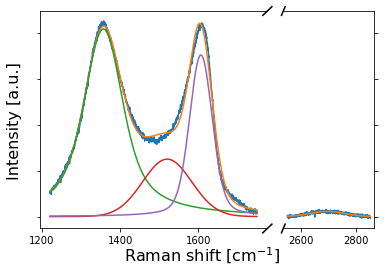

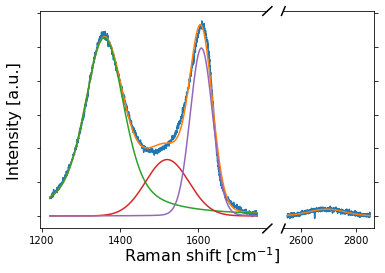

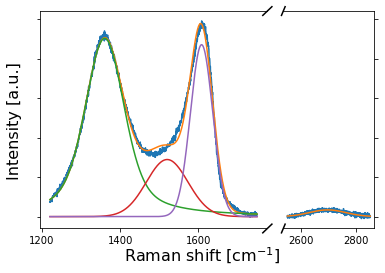

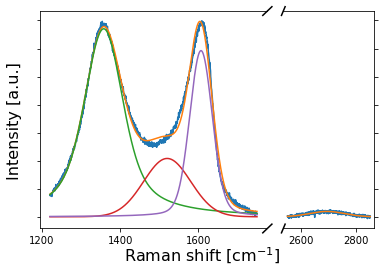

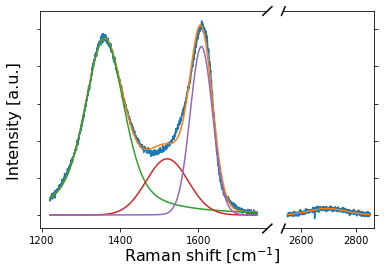

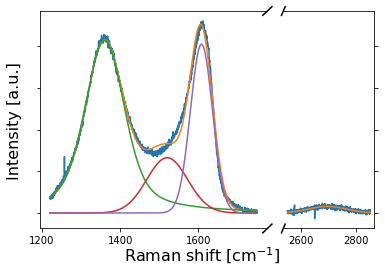

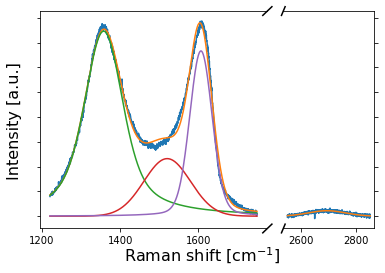

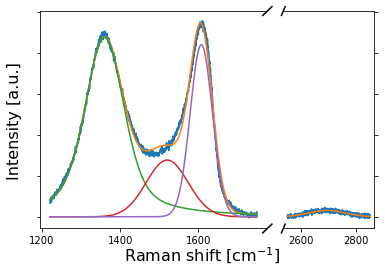

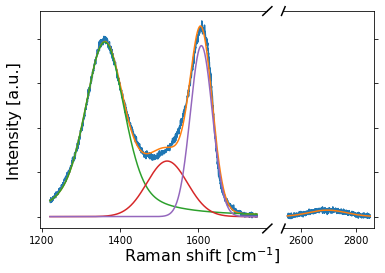

In [24]:
import os
os.chdir(r'C:\Users\UWAdmin\line stuff\defocus campaign\c4\dz 0.1 z7.4 x9.5 y8\before')
fit=[]
for i in range(0,9,1):
    d1 = pd.read_csv(one[i])
    d2 = pd.read_csv(two[i])
    _d1 = pd.read_csv(bg[0])
    _d2 = pd.read_csv(bg[1])
    
    f=new_plot_LIG(d1,d2,_d1,_d2,i)
    print(f)
    fit.append(f)

In [ ]:
print(one[9])
two[0]
d1 = pd.read_csv(one[9])
d2 = pd.read_csv(two[9])
_d1 = pd.read_csv(bg[0])
_d2 = pd.read_csv(bg[1])
f=new_plot_LIG(d1,d2,_d1,_d2)

In [26]:
import os
os.chdir(r'C:\Users\UWAdmin\line stuff\Campaign 2020-11-30\line 1 6.5 8\back')
os.getcwd()

'C:\\Users\\UWAdmin\\line stuff\\Campaign 2020-11-30\\line 1 6.5 8\\back'

In [27]:
import pandas as pd
# columns = ['GD','2DG', '2D', 'G', 'D', 'WD', 'WG']
 
    
columns= ['D','PD','WD','FD','D1','PD1','WD1','FD1','G','PG','WG','FG','2D','P2D','W2D','F2D']
     

data = np.array([np.arange(10.0)]*16).T
df2 = pd.DataFrame(data,columns=columns)

for i in range(9):
    df2['D'][i]=fit[i][0]
    df2['PD'][i]=fit[i][1]
    df2['WD'][i]=fit[i][2]
    df2['FD'][i]=fit[i][3]
    df2['D1'][i]=fit[i][4]
    df2['PD1'][i]=fit[i][5]
    df2['WD1'][i]=fit[i][6]
    df2['FD1'][i]=fit[i][7]
    df2['G'][i]=fit[i][8]
    df2['PG'][i]=fit[i][9]
    df2['WG'][i]=fit[i][10]
    df2['FG'][i]=fit[i][11]
    df2['2D'][i]=fit[i][12]
    df2['P2D'][i]=fit[i][13]
    df2['W2D'][i]=fit[i][14]
    df2['F2D'][i]=fit[i][15]
    #print("\n",fit[i][14],df2['GD'][i])
    
df2.to_csv('new_fit_data.csv')